# Histone modifications

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

random_seed = 123
np.random.seed(random_seed)

[PyCaret](https://pycaret.org/) is an open source, low-code machine learning library in Python that allows you to go from preparing your data to deploying your model within minutes in your choice of notebook environment.

It is not available by default, so we first install the library.

In [43]:
! pip install pycaret

# 1. The data

Histone modifications play an important role in affecting gene regulation. Specific histone modifications at specific locations in or near the gene can alter the expression of genes. Predicting gene expression from histone modification signals is a widely studied research topic.

In this competition you will predict gene expression levels (low=0, high=1) based on the presence of histone modifications at specific locations in the gene. You will try to find the model that learns the true underlying model best.

For each gene a region of 10.000bp around the transcription start site of the gene is extracted (5000bp upstream and 5000bp downstream). This region is binned in 100 bins of 100bp. For each bin five core histone modification marks are counted [1].

The dataset is compiled from the "E047" (Primary T CD8+ naive cells from peripheral blood) celltype from Roadmap Epigenomics Mapping Consortium (REMC) database.

[1] Kundaje, A. et al. Integrative analysis of 111 reference human epige-
nomes. Nature, 518, 317–330, 2015.


We start by loading the Pandas library and reading the datasets into Pandas DataFrames:

In [44]:
import pandas as pd

train = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/ML-course-VIB-2020/master/data_train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/ML-course-VIB-2020/master/data_test.csv")

Let's look at a random sample of the trainset:

In [45]:
train.sample(20)

,GeneId,H3K4me3_0,H3K4me1_0,H3K36me3_0,H3K9me3_0,H3K27me3_0,H3K4me3_1,H3K4me1_1,H3K36me3_1,H3K9me3_1,H3K27me3_1,H3K4me3_2,H3K4me1_2,H3K36me3_2,H3K9me3_2,H3K27me3_2,H3K4me3_3,H3K4me1_3,H3K36me3_3,H3K9me3_3,H3K27me3_3,H3K4me3_4,H3K4me1_4,H3K36me3_4,H3K9me3_4,H3K27me3_4,H3K4me3_5,H3K4me1_5,H3K36me3_5,H3K9me3_5,H3K27me3_5,H3K4me3_6,H3K4me1_6,H3K36me3_6,H3K9me3_6,H3K27me3_6,H3K4me3_7,H3K4me1_7,H3K36me3_7,H3K9me3_7,...,H3K4me1_92,H3K36me3_92,H3K9me3_92,H3K27me3_92,H3K4me3_93,H3K4me1_93,H3K36me3_93,H3K9me3_93,H3K27me3_93,H3K4me3_94,H3K4me1_94,H3K36me3_94,H3K9me3_94,H3K27me3_94,H3K4me3_95,H3K4me1_95,H3K36me3_95,H3K9me3_95,H3K27me3_95,H3K4me3_96,H3K4me1_96,H3K36me3_96,H3K9me3_96,H3K27me3_96,H3K4me3_97,H3K4me1_97,H3K36me3_97,H3K9me3_97,H3K27me3_97,H3K4me3_98,H3K4me1_98,H3K36me3_98,H3K9me3_98,H3K27me3_98,H3K4me3_99,H3K4me1_99,H3K36me3_99,H3K9me3_99,H3K27me3_99,Label
9224,7775,0,1,0,0,2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,4,2,0,2,2,7,2,1,3,1,4,1,1,4,...,2,1,1,2,0,1,0,0,1,0,0,2,1,0,0,1,3,1,1,1,1,1,1,2,0,0,0,0,1,0,0,0,0,0,0,0,1,2,0,1
6624,7005,0,2,2,0,1,0,4,2,1,0,1,3,1,2,1,1,10,1,2,0,1,1,2,0,0,1,3,1,0,1,1,2,0,1,2,1,4,3,0,...,1,0,0,0,2,5,0,0,3,0,5,0,0,0,0,4,0,1,0,1,1,0,1,0,1,1,1,2,1,0,0,1,2,2,1,0,0,1,2,0
7349,5082,0,0,0,1,1,0,0,2,0,1,0,1,0,0,1,0,2,1,0,1,0,2,2,2,0,0,0,2,2,2,1,1,0,0,2,1,1,0,3,...,3,7,1,0,0,0,5,0,0,0,2,1,1,0,0,2,8,0,0,0,1,8,0,0,0,0,4,2,1,1,0,9,1,3,0,1,6,0,4,1
1077,10976,1,0,0,2,0,2,1,0,0,1,5,0,3,3,1,8,2,1,2,2,5,0,0,2,1,7,0,0,3,1,5,1,2,2,0,4,1,3,2,...,1,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
758,4730,0,0,2,0,0,0,0,1,0,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,2,0,0,0,0,1,1,1,1,0,1,2,1,0,...,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,3,0,0,0,1,2,3,0,0,0,0,1,1,0,1,0,0,2,2,1,1,1,0
3591,79,4,1,1,0,2,2,1,1,1,2,1,0,1,2,1,0,1,1,3,1,1,4,2,5,1,1,4,1,0,2,3,2,1,2,2,2,0,0,2,...,1,0,0,1,1,1,1,1,2,0,1,2,1,0,3,3,2,0,0,2,2,2,2,1,4,4,4,4,3,2,1,3,1,2,0,1,2,0,0,0
8068,14868,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,2,1,2,0,2,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2106,7567,0,0,0,0,0,4,0,0,0,0,4,1,2,1,1,1,2,2,2,0,0,2,0,0,0,1,1,0,0,1,1,1,2,1,2,3,0,0,4,...,0,0,0,1,0,1,0,1,1,1,1,0,1,0,1,0,0,0,0,2,0,1,1,1,2,0,0,0,0,4,0,0,0,0,2,1,0,0,0,0
9300,2981,2,4,0,1,1,1,2,1,2,0,1,2,3,3,0,1,2,4,2,0,1,4,2,0,0,2,4,1,1,0,1,1,0,0,0,2,0,0,0,...,2,2,1,1,5,1,1,2,1,2,1,1,3,0,0,1,0,4,1,0,2,1,3,3,0,0,2,1,0,1,0,1,0,1,2,0,0,3,1,1
1138,11519,2,1,0,0,0,0,0,0,0,0,3,4,2,0,0,2,3,1,2,0,2,4,2,3,1,0,4,2,1,2,1,0,0,0,1,0,0,1,2,...,1,2,3,2,4,1,0,3,1,5,0,1,5,1,3,0,0,2,1,2,0,0,2,1,1,0,0,2,1,2,0,0,3,1,1,3,3,2,0,0


An alternative visualization for this type of counting data is the heatmap:

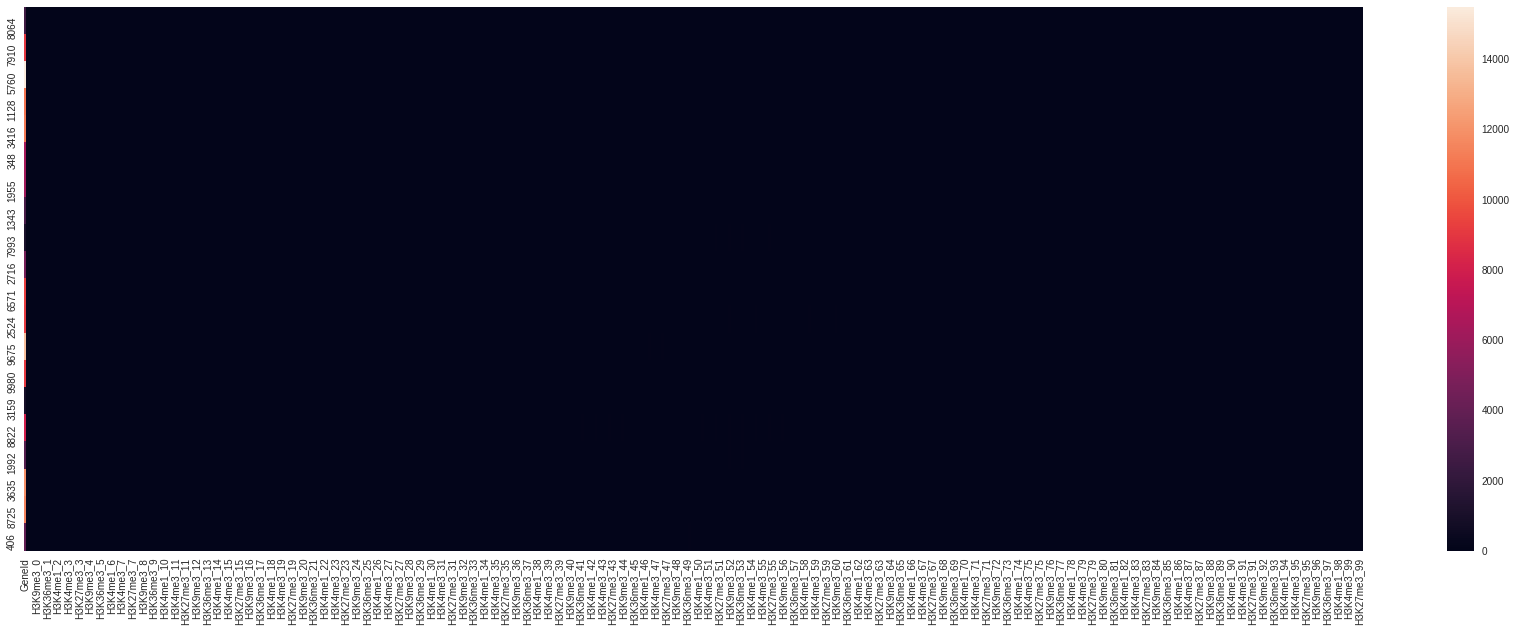

In [46]:
import seaborn as sns

plt.figure(figsize=(30,10))
sns.heatmap(train.sample(20))

The label for each datapoint is in the `Label` column.

In [47]:
train.pop("GeneId") #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
train_labels = train.pop("Label")

Now `train` contains the feature columns only.

Let's look at the number datapoints in each class:

In [48]:
train_labels.value_counts()

1    5250
0    5186
Name: Label, dtype: int64

Let's look at `test`:

In [49]:
test.head(5)

,GeneId,H3K4me3_0,H3K4me1_0,H3K36me3_0,H3K9me3_0,H3K27me3_0,H3K4me3_1,H3K4me1_1,H3K36me3_1,H3K9me3_1,H3K27me3_1,H3K4me3_2,H3K4me1_2,H3K36me3_2,H3K9me3_2,H3K27me3_2,H3K4me3_3,H3K4me1_3,H3K36me3_3,H3K9me3_3,H3K27me3_3,H3K4me3_4,H3K4me1_4,H3K36me3_4,H3K9me3_4,H3K27me3_4,H3K4me3_5,H3K4me1_5,H3K36me3_5,H3K9me3_5,H3K27me3_5,H3K4me3_6,H3K4me1_6,H3K36me3_6,H3K9me3_6,H3K27me3_6,H3K4me3_7,H3K4me1_7,H3K36me3_7,H3K9me3_7,...,H3K4me3_92,H3K4me1_92,H3K36me3_92,H3K9me3_92,H3K27me3_92,H3K4me3_93,H3K4me1_93,H3K36me3_93,H3K9me3_93,H3K27me3_93,H3K4me3_94,H3K4me1_94,H3K36me3_94,H3K9me3_94,H3K27me3_94,H3K4me3_95,H3K4me1_95,H3K36me3_95,H3K9me3_95,H3K27me3_95,H3K4me3_96,H3K4me1_96,H3K36me3_96,H3K9me3_96,H3K27me3_96,H3K4me3_97,H3K4me1_97,H3K36me3_97,H3K9me3_97,H3K27me3_97,H3K4me3_98,H3K4me1_98,H3K36me3_98,H3K9me3_98,H3K27me3_98,H3K4me3_99,H3K4me1_99,H3K36me3_99,H3K9me3_99,H3K27me3_99
0,5222,2,2,7,2,0,3,2,9,2,0,1,7,8,1,0,0,2,5,4,0,0,2,5,2,0,2,4,10,3,0,0,4,10,1,0,1,2,6,2,...,1,1,2,0,3,3,1,1,0,1,2,2,0,2,1,3,1,0,2,1,2,0,1,0,1,0,0,0,1,0,0,2,1,1,0,0,3,1,1,1
1,891,1,2,0,0,1,0,4,1,2,4,1,2,2,3,4,1,1,2,3,1,2,2,3,1,1,1,0,0,0,0,0,0,0,0,1,2,0,0,0,...,0,3,0,2,3,0,1,1,3,0,1,0,1,1,3,1,0,0,0,1,1,0,0,0,0,3,3,0,1,0,3,2,2,2,0,4,2,5,2,1
2,7219,1,1,2,4,4,2,2,1,1,1,2,0,0,3,1,3,0,0,2,1,2,1,2,1,0,1,1,2,0,1,0,1,1,2,0,2,1,1,3,...,2,0,1,0,1,2,0,1,1,1,2,2,1,2,2,2,1,2,2,0,0,2,0,1,2,3,4,1,1,0,1,3,1,1,0,0,1,1,1,0
3,7225,1,5,2,4,1,0,8,3,4,0,0,3,2,2,0,0,0,1,0,0,2,0,1,2,1,2,2,2,2,2,1,5,0,0,0,1,4,2,2,...,2,7,0,4,2,0,2,0,4,1,0,2,1,2,1,0,3,0,3,0,1,0,0,2,2,0,1,0,0,4,0,2,1,1,2,1,1,0,2,0
4,9432,1,16,3,2,2,2,7,0,4,2,0,5,1,1,2,0,4,1,0,2,0,4,1,1,2,0,3,2,2,2,0,1,2,1,3,1,5,2,0,...,1,0,1,1,0,3,1,2,1,1,2,0,3,3,0,4,2,3,2,1,4,2,2,1,3,3,0,0,0,3,0,1,2,0,1,1,1,1,2,1


This is a blind test so the `Label` column is not available in the testset. The testset does contain the `GeneId` column that is needed to send your predictions to the Kaggle website.


In [50]:
test_index_col = test.pop("GeneId")

We can compute some decriptive statistics about the trainset using the DataFrame `.describe()` function:

In [51]:
train.describe()

,H3K4me3_0,H3K4me1_0,H3K36me3_0,H3K9me3_0,H3K27me3_0,H3K4me3_1,H3K4me1_1,H3K36me3_1,H3K9me3_1,H3K27me3_1,H3K4me3_2,H3K4me1_2,H3K36me3_2,H3K9me3_2,H3K27me3_2,H3K4me3_3,H3K4me1_3,H3K36me3_3,H3K9me3_3,H3K27me3_3,H3K4me3_4,H3K4me1_4,H3K36me3_4,H3K9me3_4,H3K27me3_4,H3K4me3_5,H3K4me1_5,H3K36me3_5,H3K9me3_5,H3K27me3_5,H3K4me3_6,H3K4me1_6,H3K36me3_6,H3K9me3_6,H3K27me3_6,H3K4me3_7,H3K4me1_7,H3K36me3_7,H3K9me3_7,H3K27me3_7,...,H3K4me3_92,H3K4me1_92,H3K36me3_92,H3K9me3_92,H3K27me3_92,H3K4me3_93,H3K4me1_93,H3K36me3_93,H3K9me3_93,H3K27me3_93,H3K4me3_94,H3K4me1_94,H3K36me3_94,H3K9me3_94,H3K27me3_94,H3K4me3_95,H3K4me1_95,H3K36me3_95,H3K9me3_95,H3K27me3_95,H3K4me3_96,H3K4me1_96,H3K36me3_96,H3K9me3_96,H3K27me3_96,H3K4me3_97,H3K4me1_97,H3K36me3_97,H3K9me3_97,H3K27me3_97,H3K4me3_98,H3K4me1_98,H3K36me3_98,H3K9me3_98,H3K27me3_98,H3K4me3_99,H3K4me1_99,H3K36me3_99,H3K9me3_99,H3K27me3_99
count,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.00000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,...,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000
mean,1.482081,1.738885,2.342564,1.887792,1.134438,1.486393,1.738310,2.354159,1.906957,1.121694,1.479398,1.722116,2.363549,1.885684,1.137505,1.463971,1.726907,2.377923,1.893158,1.138271,1.471158,1.741663,2.400441,1.927846,1.121598,1.477578,1.708126,2.442986,1.920468,1.124952,1.503929,1.720966,2.462342,1.905232,1.13578,1.520123,1.681296,2.461575,1.921522,1.139613,...,1.488597,1.718570,2.509870,1.815447,1.099463,1.479494,1.721732,2.465025,1.797240,1.107512,1.463588,1.717133,2.473649,1.775201,1.115178,1.466175,1.740705,2.413664,1.776639,1.110100,1.457167,1.746359,2.429571,1.757857,1.119394,1.460234,1.759007,2.436182,1.748946,1.123131,1.458413,1.754120,2.437236,1.800882,1.141050,1.455922,1.738022,2.397183,1.826945,1.129935
std,1.883112,2.098565,3.798700,5.292531,1.455765,1.925768,2.094562,3.784454,5.334868,1.417511,1.877427,2.077745,3.781689,5.448426,1.420828,1.889508,2.109728,3.809019,5.403684,1.433245,1.879410,2.134382,3.842186,5.459619,1.427255,1.893214,2.053826,3.897871,5.360578,1.430956,1.900113,2.075560,3.897860,5.214749,1.40294,1.897235,2.015560,3.922654,5.145834,1.406044,...,1.846211,2.103376,3.964094,4.675360,1.375978,1.877275,2.083267,3.886855,4.592894,1.365022,1.836466,2.082509,3.955112,4.705680,1.377259,1.846092,2.125807,3.919961,4.710155,1.408323,1.799267,2.152224,3.902467,4.626802,1.385227,1.800774,2.146947,3.959504,4.483866,1.422415,1.840630,2.155949,3.950022,4.797043,1.455172,1.842602,2.134836,3.892699,4.924786,1.472372
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

We can plot these descriptive statistics to get a general overview of the data.

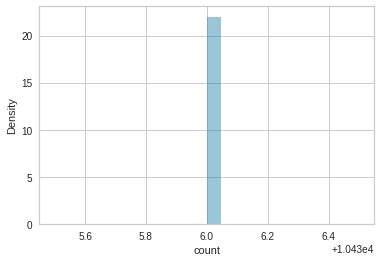

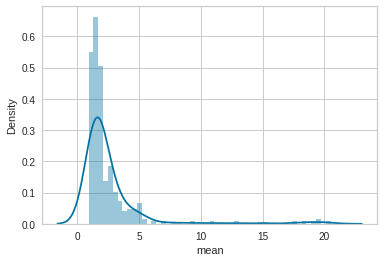

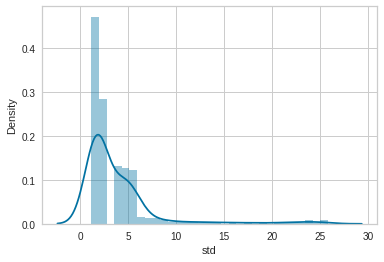

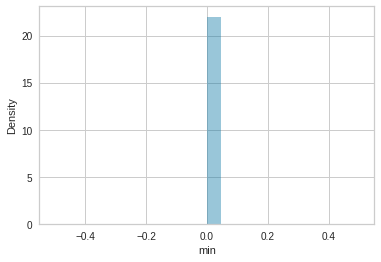

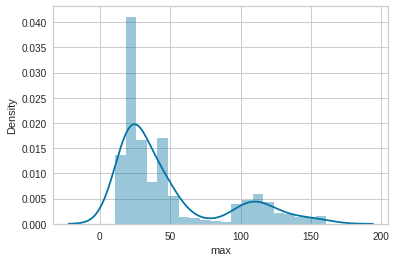

In [52]:
for col in ["count","mean","std","min","max"]:
  sns.distplot(pd.DataFrame(train.describe().transpose())[col])
  plt.show()

We can use the Pandas `boxplot()` function to plot the feature values.

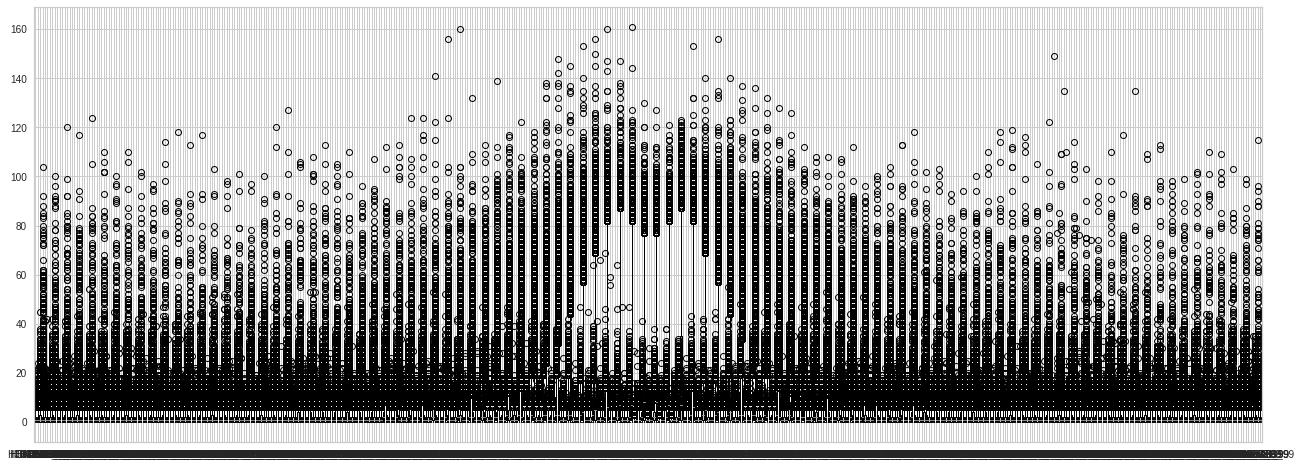

In [53]:
plt.figure(figsize=(22,8))
train.boxplot()
plt.show()

Let's plot these for each hisotone mark.

In [54]:
marks = {}
for m in train.columns:
  marks[m.split("_")[0]] = True
marks = list(marks.keys())
marks

['H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'H3K27me3']

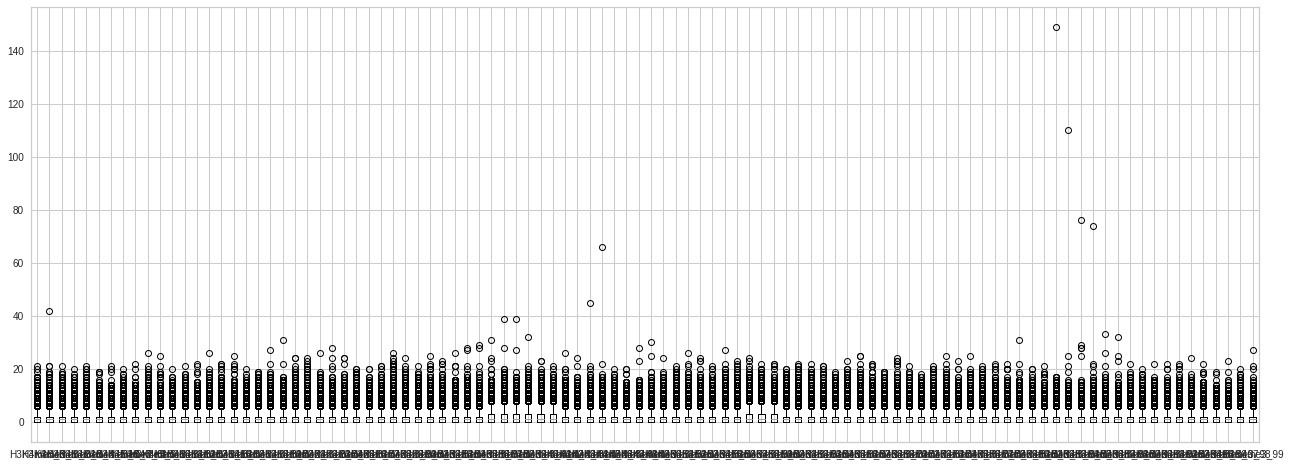

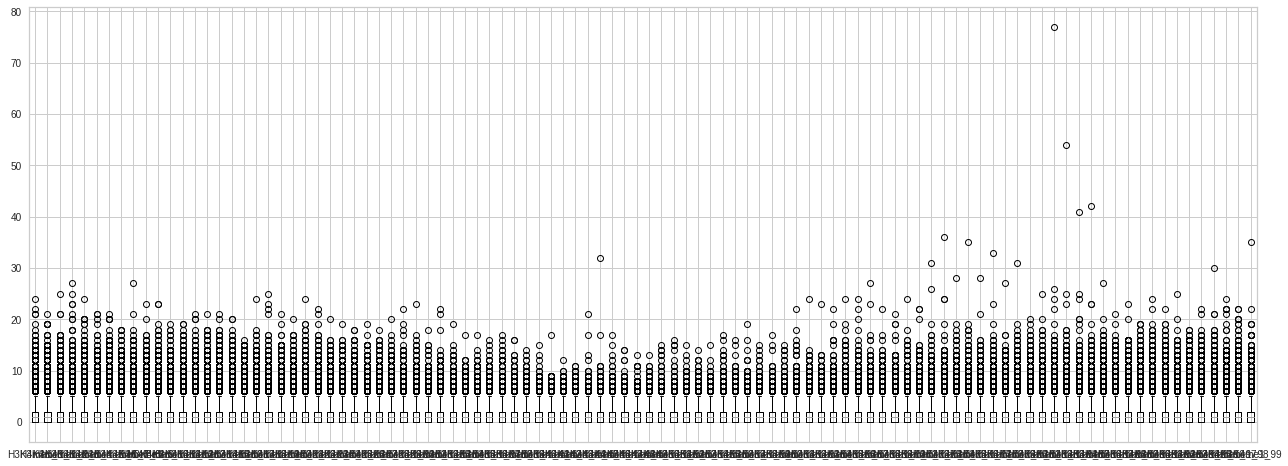

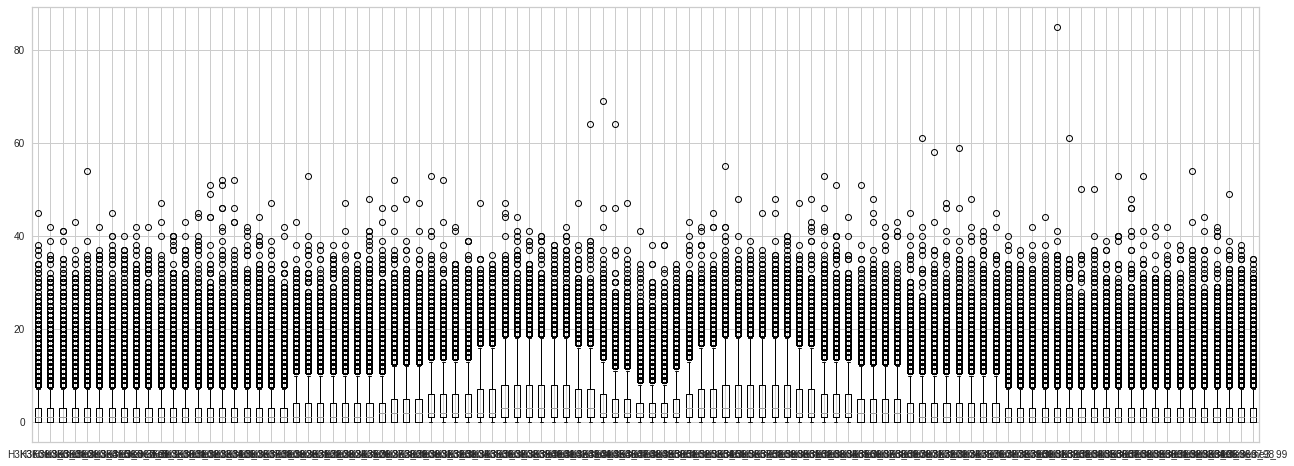

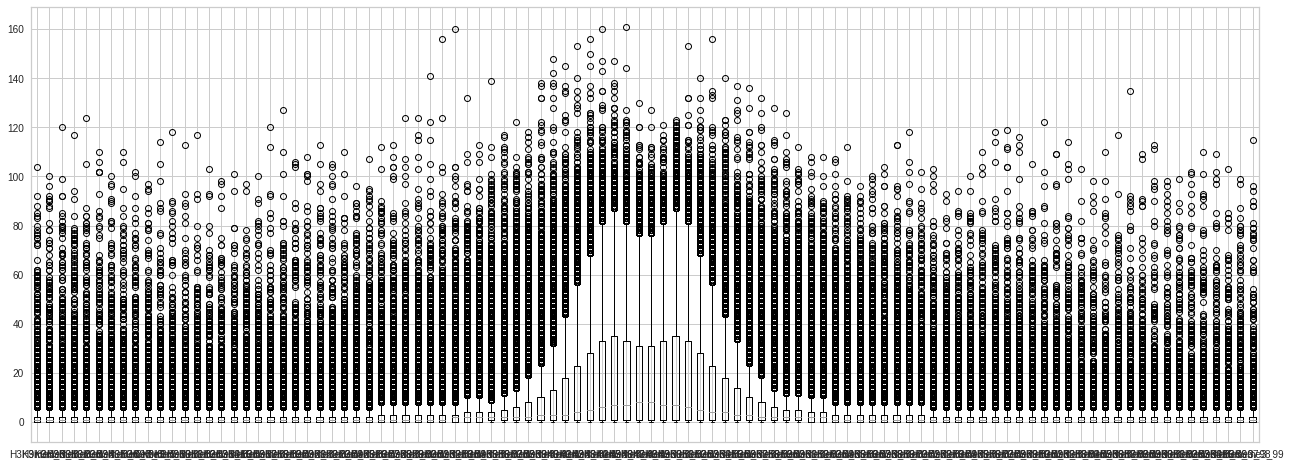

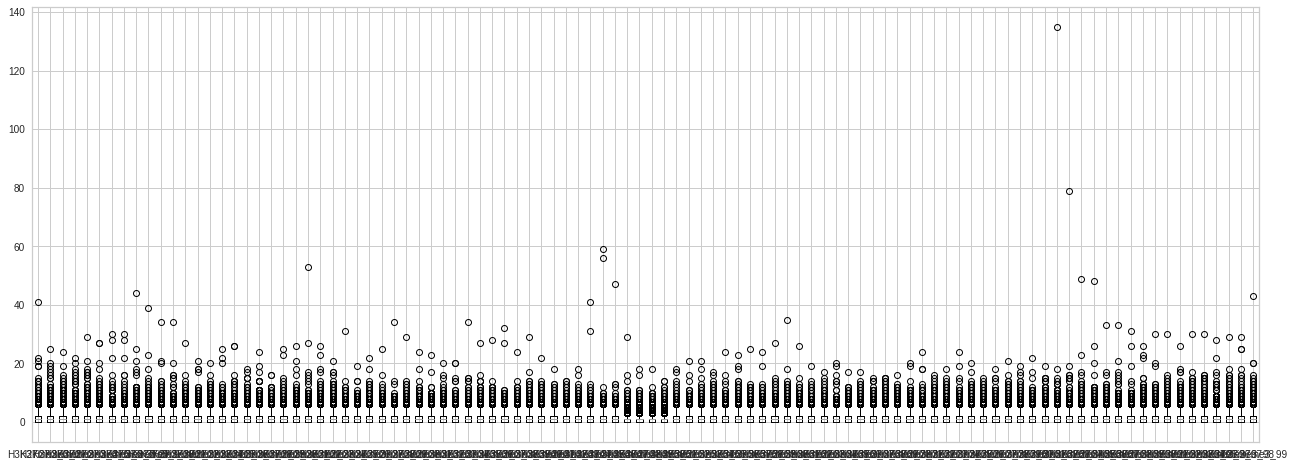

In [55]:
for mark in marks:
  cols = []
  for m in train.columns:
    if mark in m:
      cols.append(m)
  plt.figure(figsize=(22,8))    
  train[cols].boxplot()
  plt.show()

# 2. Our first model

Let's fit a Logistic Regression model. We will first use the very popular (with good reason) [Scikit-learn](https://scikit-learn.org/stable/) library for that.

First, we randomly split the trainingset into a part for fitting (80%) and a part for evaluation (20%).

Next, we fit the modelparameters on the the fitting part and evaluate the fitted model on the evaluation part.

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(train,train_labels,
                                                  test_size=.2, random_state=random_seed)

cls = LogisticRegression()

cls.fit(train_X,train_y)

predictions_train = cls.predict(train_X)
predictions_val = cls.predict(val_X)

print("Accuracy: (%f) %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))

Accuracy: (0.867154) 0.838602


# 3. How well does it perform in pratice?

In [57]:
#code for submission
predictions_test = cls.predict(test)

to_write = pd.DataFrame()
to_write["GeneId"] = test_index_col
to_write["Label"] = predictions_test
to_write.to_csv("submission1.csv",index=False)

For the Kaggle competition your predictions are not evaluated by accuracy, but by log-loss:

$$ - \frac{1}{N} \sum_{i=1}^N [y_{i} \log \, p_{i} + (1 - y_{i}) \log \, (1 - p_{i})],$$

where $N$ is the number of datapoints, $y_i$ is the label of datapoint $i$, and $p_i$ is the prediction of the model expressed as a probability.

Let's compute the log-loss:

In [58]:
predictions_train_prob = cls.predict(train_X)
predictions_val_prob = cls.predict(val_X)

print("Log-loss: (%f) %f"%(log_loss(train_y,predictions_train_prob),log_loss(val_y,predictions_val_prob)))

Log-loss: (4.588397) 5.574569


# 4. Data pre-processing




Let's scale all the features to [0,1]:

In [59]:
from sklearn import preprocessing

scaler_minmax = preprocessing.MinMaxScaler()
scaler_minmax.fit(train)
train_norm = pd.DataFrame(scaler_minmax.transform(train),columns=train.columns)
train_norm.head()

,H3K4me3_0,H3K4me1_0,H3K36me3_0,H3K9me3_0,H3K27me3_0,H3K4me3_1,H3K4me1_1,H3K36me3_1,H3K9me3_1,H3K27me3_1,H3K4me3_2,H3K4me1_2,H3K36me3_2,H3K9me3_2,H3K27me3_2,H3K4me3_3,H3K4me1_3,H3K36me3_3,H3K9me3_3,H3K27me3_3,H3K4me3_4,H3K4me1_4,H3K36me3_4,H3K9me3_4,H3K27me3_4,H3K4me3_5,H3K4me1_5,H3K36me3_5,H3K9me3_5,H3K27me3_5,H3K4me3_6,H3K4me1_6,H3K36me3_6,H3K9me3_6,H3K27me3_6,H3K4me3_7,H3K4me1_7,H3K36me3_7,H3K9me3_7,H3K27me3_7,...,H3K4me3_92,H3K4me1_92,H3K36me3_92,H3K9me3_92,H3K27me3_92,H3K4me3_93,H3K4me1_93,H3K36me3_93,H3K9me3_93,H3K27me3_93,H3K4me3_94,H3K4me1_94,H3K36me3_94,H3K9me3_94,H3K27me3_94,H3K4me3_95,H3K4me1_95,H3K36me3_95,H3K9me3_95,H3K27me3_95,H3K4me3_96,H3K4me1_96,H3K36me3_96,H3K9me3_96,H3K27me3_96,H3K4me3_97,H3K4me1_97,H3K36me3_97,H3K9me3_97,H3K27me3_97,H3K4me3_98,H3K4me1_98,H3K36me3_98,H3K9me3_98,H3K27me3_98,H3K4me3_99,H3K4me1_99,H3K36me3_99,H3K9me3_99,H3K27me3_99
0,0.047619,0.041667,0.044444,0.009615,0.073171,0.023810,0.095238,0.119048,0.00,0.04,0.047619,0.12,0.195122,0.041667,0.125000,0.00,0.074074,0.186047,0.017094,0.272727,0.047619,0.000000,0.074074,0.024194,0.068966,0.000000,0.000000,0.047619,0.009091,0.000000,0.095238,0.047619,0.155556,0.05,0.000000,0.00,0.055556,0.15,0.009091,0.066667,...,0.045455,0.636364,0.714286,0.071429,0.133333,0.045455,0.64,0.552632,0.060606,0.038462,0.041667,0.666667,0.574074,0.039216,0.133333,0.000000,0.454545,0.704545,0.081818,0.033333,0.052632,0.566667,0.547619,0.027523,0.071429,0.086957,0.333333,0.326531,0.058252,0.103448,0.10,0.500000,0.394737,0.050505,0.068966,0.074074,0.285714,0.342857,0.017391,0.046512
1,0.000000,0.000000,0.022222,0.009615,0.000000,0.047619,0.000000,0.047619,0.00,0.08,0.095238,0.00,0.024390,0.000000,0.041667,0.05,0.000000,0.023256,0.000000,0.000000,0.047619,0.000000,0.018519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.00,0.000000,0.05,0.000000,0.00,0.000000,0.000000,...,0.136364,0.136364,0.000000,0.000000,0.000000,0.227273,0.08,0.026316,0.000000,0.000000,0.041667,0.055556,0.037037,0.019608,0.033333,0.090909,0.090909,0.022727,0.036364,0.033333,0.105263,0.033333,0.000000,0.018349,0.000000,0.000000,0.041667,0.020408,0.000000,0.000000,0.05,0.045455,0.000000,0.000000,0.000000,0.037037,0.028571,0.000000,0.000000,0.000000
2,0.333333,0.125000,0.022222,0.009615,0.024390,0.095238,0.095238,0.023810,0.01,0.08,0.095238,0.08,0.097561,0.008333,0.000000,0.05,0.037037,0.000000,0.000000,0.000000,0.190476,0.041667,0.000000,0.008065,0.034483,0.421053,0.095238,0.023810,0.018182,0.037037,0.190476,0.095238,0.044444,0.03,0.000000,0.05,0.111111,0.00,0.018182,0.000000,...,0.045455,0.000000,0.071429,0.000000,0.000000,0.090909,0.00,0.052632,0.010101,0.076923,0.125000,0.111111,0.055556,0.029412,0.066667,0.136364,0.045455,0.000000,0.009091,0.066667,0.105263,0.000000,0.000000,0.009174,0.107143,0.086957,0.000000,0.020408,0.009709,0.034483,0.05,0.045455,0.000000,0.020202,0.000000,0.037037,0.028571,0.028571,0.008696,0.000000
3,0.190476,0.083333,0.088889,0.009615,0.073171,0.000000,0.095238,0.023810,0.01,0.12,0.047619,0.24,0.024390,0.008333,0.041667,0.05,0.037037,0.000000,0.008547,0.045455,0.047619,0.041667,0.018519,0.000000,0.034483,0.105263,0.142857,0.023810,0.009091,0.000000,0.047619,0.047619,0.022222,0.02,0.066667,0.05,0.055556,0.05,0.009091,0.100000,...,0.045455,0.227273,0.000000,0.020408,0.000000,0.000000,0.12,0.078947,0.010101,0.038462,0.083333,0.111111,0.000000,0.000000,0.033333,0.227273,0.090909,0.045455,0.009091,0.066667,0.421053,0.033333,0.000000,0.009174,0.035714,0.086957,0.125000,0.020408,0.019417,0.068966,0.15,0.045455,0.052632,0.040404,0.068966,0.148148,0.085714,0.000000,0.000000,0.000000
4,0.047619,0.041667,0.044444,0.000000,0.195122,0.000000,0.095238,0.023810,0.01,0.12,0.000000,0.00,0.000000,0.016667,0.125000,0.05,0.111111,0.000000,0.008547,0.454545,0.047619,0.125000,0.000000,0.008065,0.275862,0.000000,0.000000,0.000000,0.027273,0.185185,0.000000,0.142857,0.044444,0.00,0.066667,0.05,0.000000,0.00,0.000000,0.100000,...,0.045455,0.045455,0.14285

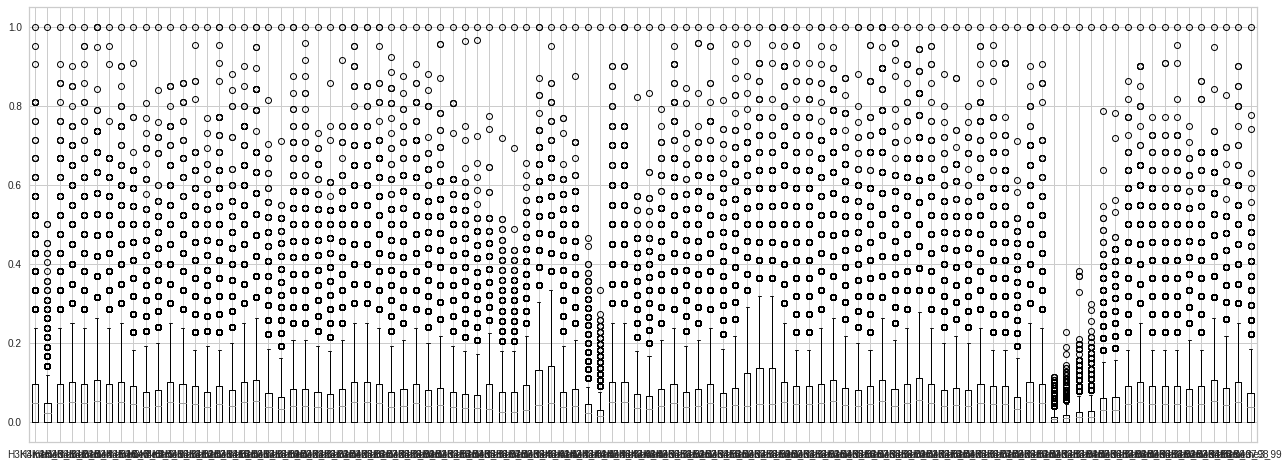

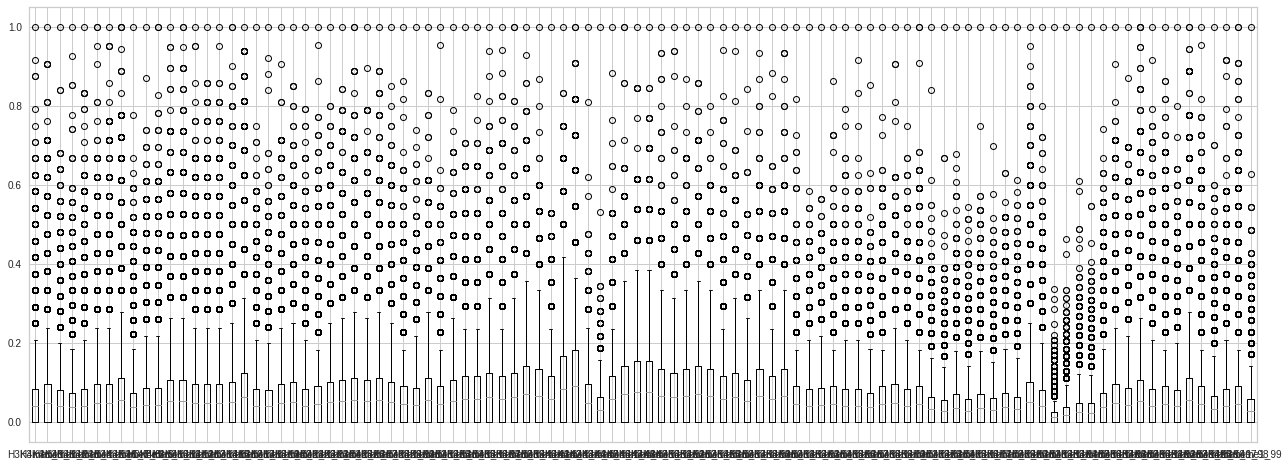

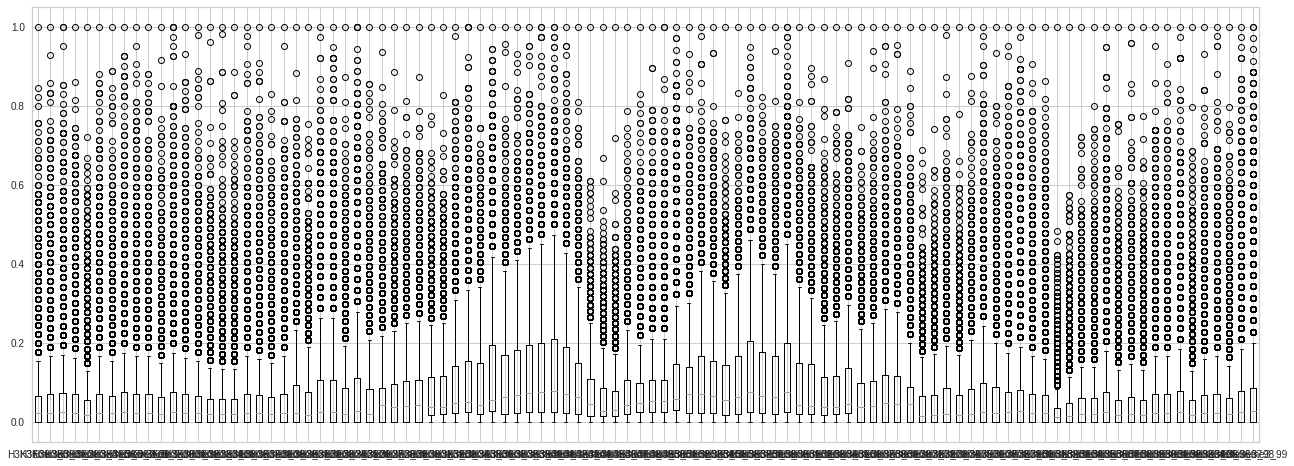

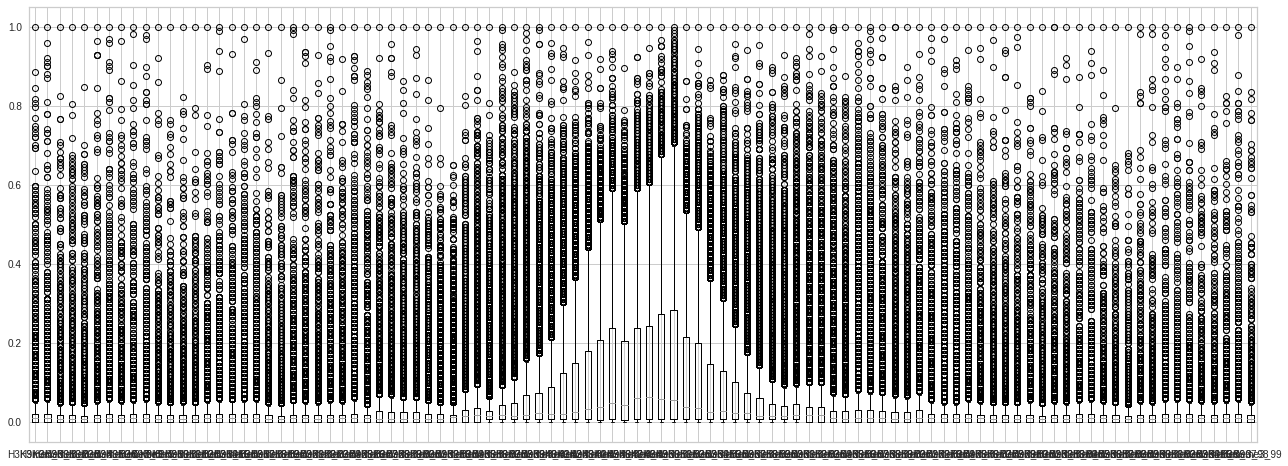

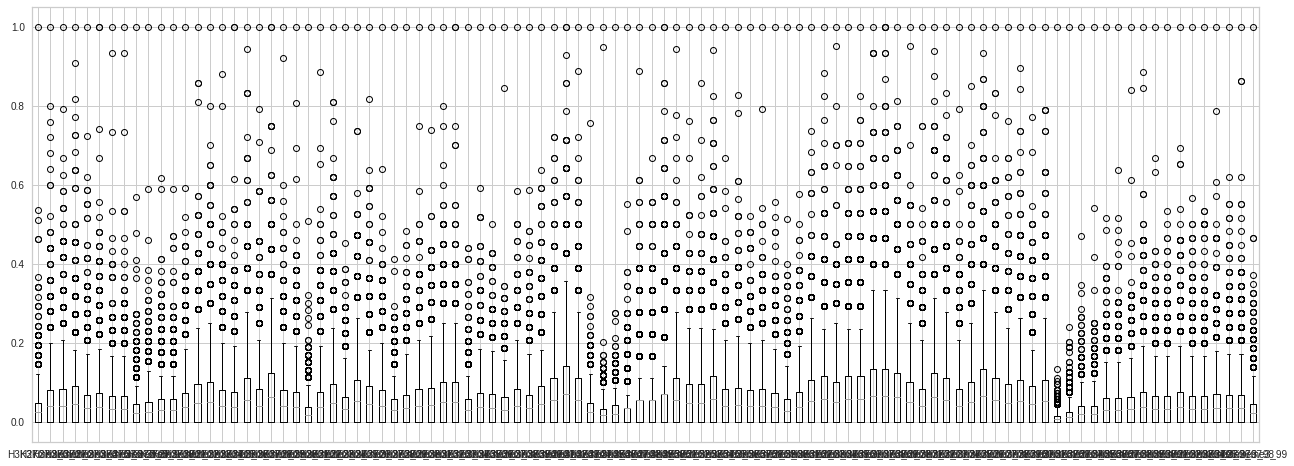

In [60]:
for mark in marks:
  cols = []
  for m in train_norm.columns:
    if mark in m:
      cols.append(m)
  plt.figure(figsize=(22,8))    
  train_norm[cols].boxplot()
  plt.show()

Now, did we improve the predictions?

In [61]:
train_X, val_X, train_y, val_y = train_test_split(train_norm,train_labels,
                                                  test_size=.2, random_state=random_seed)

cls.fit(train_X,train_y)

predictions_train = cls.predict(train_X)
predictions_val = cls.predict(val_X)

print("Accuracy: (%f) %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))

predictions_train_prob = cls.predict_proba(train_X)
predictions_val_prob = cls.predict_proba(val_X)

print("Log-loss: (%f) %f"%(log_loss(train_y,predictions_train_prob[:,1]),log_loss(val_y,predictions_val_prob[:,1])))

Accuracy: (0.863680) 0.854406
Log-loss: (0.348821) 0.375078


# 5. Hyperparameter tuning

From now on we will use the PyCaret library for fitting models. It provides many useful functions that make Machine Learning fun.

To use PyCaret we first need to setup an environment that prepares the data for fitting and evaluation.

In [62]:
from pycaret.classification import *

train_norm["Label"] = train_labels
setup(data=train_norm,target="Label",numeric_features=list(train.columns)[:-1], train_size=0.8, silent=True)

,Description,Value
0,session_id,4542
1,Target,Label
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(10436, 501)"
5,Missing Values,False
6,Numeric Features,500
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


(False, 4848     1
 9081     0
 703      1
 6651     1
 9210     0
         ..
 95       0
 7261     0
 9189     0
 6424     0
 10322    1
 Name: Label, Length: 8348, dtype: int64, -1, 'box-cox', StratifiedKFold(n_splits=10, random_state=4542, shuffle=False), False,       H3K4me3_0  H3K4me1_0  H3K36me3_0  ...  H3K36me3_99  H3K9me3_99  H3K27me3_99
 5413   0.190476   0.083333    0.022222  ...     0.200000    0.043478     0.069767
 5155   0.000000   0.083333    0.000000  ...     0.057143    0.026087     0.023256
 2942   0.000000   0.291667    0.000000  ...     0.000000    0.008696     0.023256
 1489   0.000000   0.041667    0.022222  ...     0.028571    0.008696     0.046512
 4173   0.000000   0.000000    0.000000  ...     0.000000    0.000000     0.000000
 ...         ...        ...         ...  ...          ...         ...          ...
 2409   0.190476   0.000000    0.088889  ...     0.000000    0.008696     0.046512
 3612   0.000000   0.250000    0.000000  ...     0.028571    0.026087 

By default, PyCaret does not compute the log-loss metric. So, we add it.

In [63]:
from sklearn.metrics import log_loss

add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False, target="pred_proba")

Name                                                           LogLoss
Display Name                                                   LogLoss
Score Function                   <function log_loss at 0x7fad3b81fe18>
Scorer               make_scorer(log_loss, greater_is_better=False,...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: logloss, dtype: object

Next, we fit a model using `create_model` that is similar to `fit()` in Scikit-learn, except that it fits and evaluates (CV) on the 80% fitting part only. The output of this function is a score grid with CV scores by fold.

In [64]:
lr = create_model("lr")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.8491,0.9121,0.8333,0.8621,0.8475,0.6983,0.6986,0.3802
1,0.8407,0.9084,0.8405,0.8425,0.8415,0.6814,0.6814,0.3911
2,0.8563,0.9135,0.8333,0.8750,0.8537,0.7126,0.7135,0.3794
3,0.8659,0.9124,0.8667,0.8667,0.8667,0.7317,0.7317,0.3741
4,0.8455,0.9041,0.8401,0.8502,0.8451,0.6910,0.6911,0.3994
5,0.8359,0.9055,0.8067,0.8579,0.8315,0.6719,0.6731,0.4016
6,0.8551,0.9134,0.8568,0.8548,0.8558,0.7102,0.7102,0.3804
7,0.8491,0.9101,0.8640,0.8399,0.8518,0.6982,0.6985,0.3835
8,0.8309,0.8897,0.8115,0.8458,0.8283,0.6619,0.6625,0.4365
9,0.8405,0.9101,0.8401,0.8421,0.8411,0.6811,0.6811,0.3872


We just fitted a Logistic Regression model with a default value of 1.0 for the regularization parameter. As you can see below.

In [65]:
lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=4542, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [66]:
result = predict_model(lr)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,Logistic Regression,0.8549,0.918,0.8551,0.8575,0.8563,0.7097,0.7097,0.3688


It is now easy to optimize (tune) this hyperparameter.

In [67]:
tuned_lr = tune_model(lr,tuner_verbose=2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.8467,0.9152,0.8310,0.8596,0.8450,0.6935,0.6939,0.3729
1,0.8491,0.9108,0.8429,0.8551,0.8489,0.6982,0.6983,0.3844
2,0.8563,0.9155,0.8357,0.8731,0.8540,0.7126,0.7133,0.3734
3,0.8743,0.9174,0.8786,0.8723,0.8754,0.7485,0.7485,0.3636
4,0.8527,0.9071,0.8520,0.8541,0.8530,0.7054,0.7054,0.3910
5,0.8419,0.9066,0.8091,0.8670,0.8370,0.6839,0.6854,0.3973
6,0.8575,0.9155,0.8592,0.8571,0.8582,0.7150,0.7150,0.3748
7,0.8539,0.9131,0.8687,0.8445,0.8565,0.7078,0.7080,0.3758
8,0.8345,0.8920,0.8186,0.8469,0.8325,0.6691,0.6695,0.4282
9,0.8489,0.9122,0.8544,0.8463,0.8504,0.6978,0.6979,0.3817


This is the 'optimal' value for the regularization hyperparameter.

In [68]:
tuned_lr

LogisticRegression(C=0.363, class_weight={}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=4542, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [69]:
result = predict_model(tuned_lr)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,Logistic Regression,0.8587,0.9211,0.8617,0.8593,0.8605,0.7174,0.7174,0.3618


In [70]:
evaluate_model(tuned_lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [71]:
final_lr = finalize_model(lr)

In [72]:
result = predict_model(lr,data=test)
print(result)

      H3K4me3_0  H3K4me1_0  H3K36me3_0  ...  H3K27me3_99  Label   Score
0             2          2           7  ...            1      1  1.0000
1             1          2           0  ...            1      1  1.0000
2             1          1           2  ...            0      1  1.0000
3             1          5           2  ...            0      1  1.0000
4             1         16           3  ...            1      1  1.0000
...         ...        ...         ...  ...          ...    ...     ...
5044          0          0           0  ...            2      1  1.0000
5045          1          3           3  ...            0      1  1.0000
5046          0          5           2  ...            0      1  1.0000
5047          7          1           0  ...            1      0  0.9999
5048          3          2           0  ...            3      1  1.0000

[5049 rows x 502 columns]


In [73]:
to_write = pd.DataFrame()
to_write["GeneId"] = test_index_col
to_write["Label"] = result["Score"]
to_write.to_csv("submission2.csv",index=False)